# Logistic Regression Mini-Project
#### Keiti Lo   |   April 21, 2021

In [166]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score

In [12]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [18]:
# switch to seaborn default stylistic parameters
sns.set()d
sns.set_context('notebook') 

### Read Heart Disease Data

In [84]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/heart.csv")
df['output'] = df['output'] - 1

## Initial Exploration

Check for NA values in dataset.

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        270 non-null    int64  
 1   sex        270 non-null    int64  
 2   chestpain  270 non-null    int64  
 3   restbp     270 non-null    int64  
 4   chol       270 non-null    int64  
 5   sugar      270 non-null    int64  
 6   ecg        270 non-null    int64  
 7   maxhr      270 non-null    int64  
 8   angina     270 non-null    int64  
 9   dep        270 non-null    float64
 10  exercise   270 non-null    int64  
 11  fluor      270 non-null    int64  
 12  thal       270 non-null    int64  
 13  output     270 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 29.7 KB


In [22]:
df.describe()

,age,sex,chestpain,restbp,chol,sugar,ecg,maxhr,angina,dep,exercise,fluor,thal,output
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296,0.444444
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659,0.497827
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000,0.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000,1.000000


There appears to be no missing data in the form of NA values and no obvious bad data.
Columns age, restbp, chol, maxhr, and dep are numeric variables, while the rest of them are categorical.

Now I want to take a look at numeric and categorical variables to uncover any bad data or outliers that may skew results.

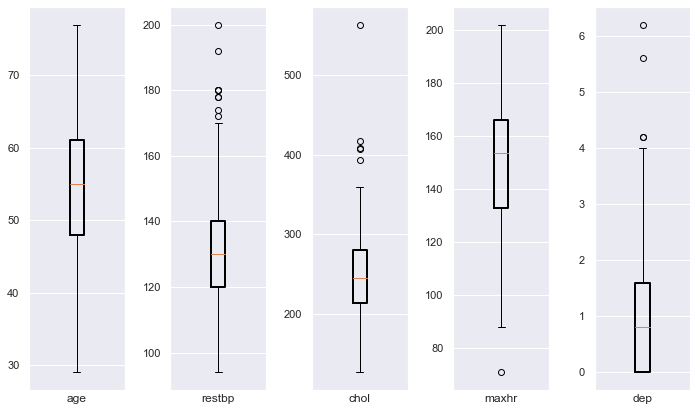

In [26]:
num_vars = ['age', 'restbp', 'chol', 'maxhr', 'dep']
fig,axs = plt.subplots(1, len(num_vars), figsize=(10,6))
fig.tight_layout()
for i,x in enumerate(num_vars):
    axs[i].boxplot(df[x].values, boxprops={'linewidth':2})
    axs[i].set_xlabel(x)
    axs[i].set_xticks([])

Looking at box plots for the numeric variables, 'chol' and 'dep' have a few outliers that I will get rid of.

In [90]:
df.drop(df[df['chol'] > 500].index, inplace = True)
df.drop(df[df['dep'] > 5].index, inplace = True)

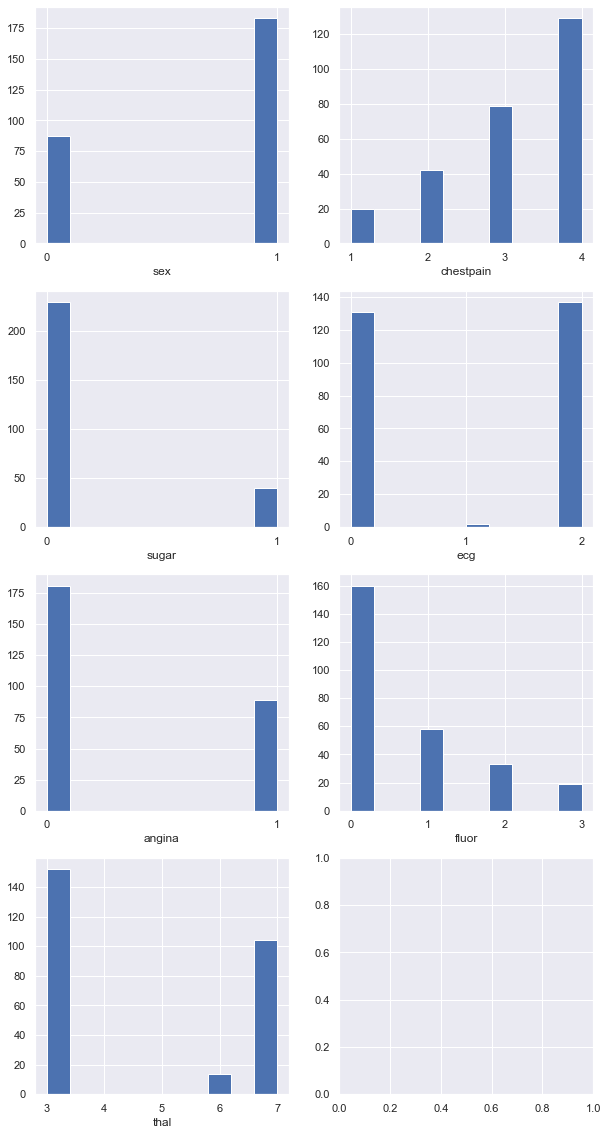

In [67]:
cat_vars = ['sex','chestpain', 'sugar', 'ecg', 'angina', 'fluor', 'thal']
fig, ax = plt.subplots(4,2, figsize=(10,20))
for i,x in enumerate(cat_vars):
    ax[i//2,i%2].hist(df[x])
    ax[i//2,i%2].set_xticks(range(min(df[x]), max(df[x])+1))
    ax[i//2,i%2].set_xlabel(x)

The histogram shows that the variables are overall relatively unbalanced, which is something to keep in mind when training data. At first glance, the ecg variable looks like it's very balanced, at almost 50-50, but when I looked closely, I realized there's a third category that has very little data, so I will be removing the two rows that have that value.

In [93]:
df.drop(df[df['ecg'] == 1].index, inplace = True)

## Data Exploration

Now that I've cleaned up the data, I want to take a look at the numeric variables and see if there are any correlations between variables.

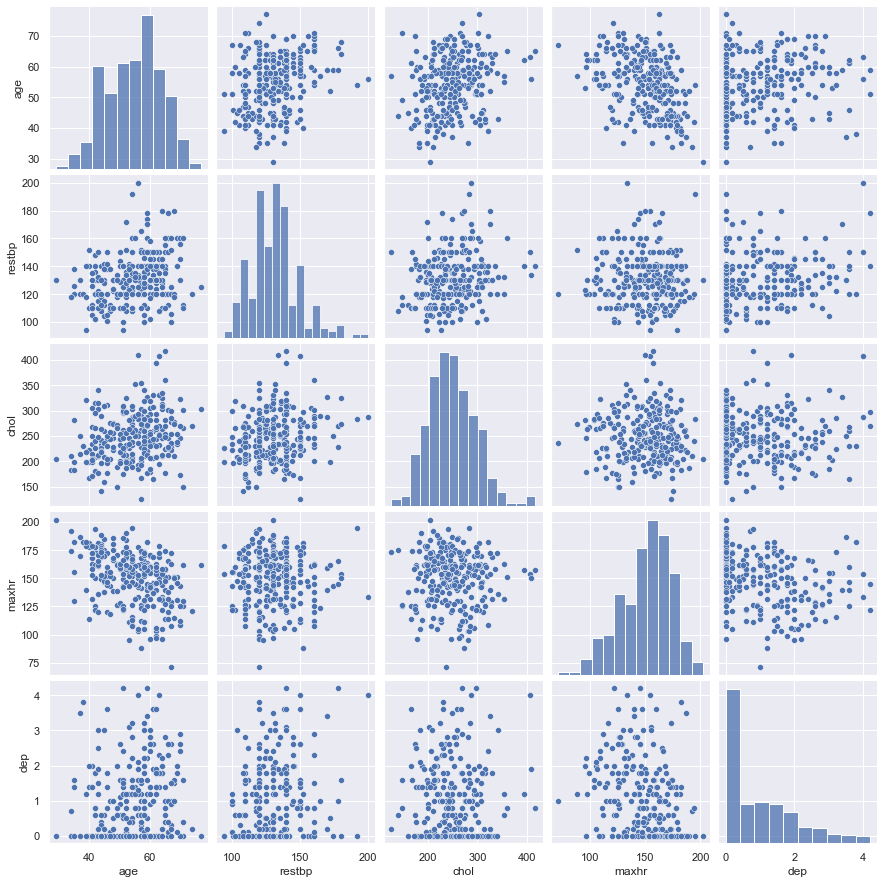

In [105]:
sns.pairplot(df, vars=['age', 'restbp', 'chol', 'maxhr', 'dep']);

The pairplot shows that there aren't strong correlations between any two numeric variables. There is a slight positive correlation between cholesterol and max heart rate, and a slight negative correlation bewtween max heart rate and age, which I found pretty interesting. I expected the higher the age, the higher the max heart rate.

At first, I was plotting different combinations of variables with output as the hue, but I realized I could do another pairplot with output as hue to see how different combinations of numeric variables might indicate heart disease.

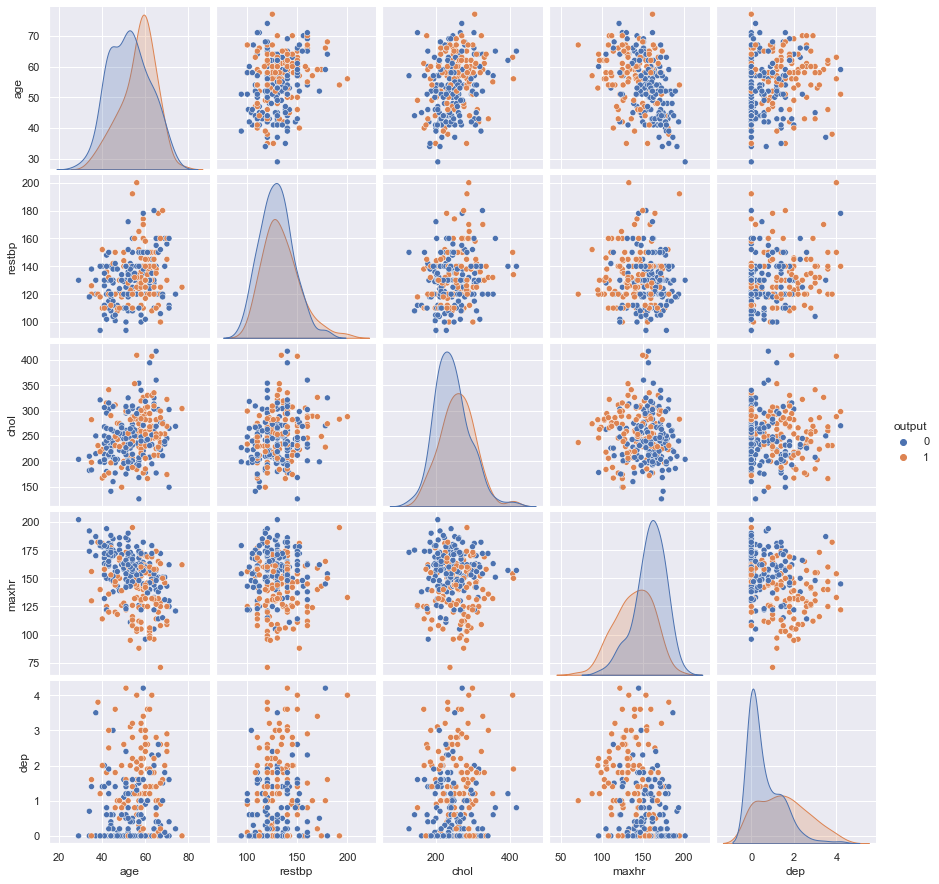

In [106]:
sns.pairplot(df, vars=['age', 'restbp', 'chol', 'maxhr', 'dep'], hue='output');

This plot surprised me because I was expecting some combinations like higher 'restbp' and highter 'chol' to indicate a higher chance of having heart disease, but it looks like the only two variables where heart disease visibly relates to the variable are 'dep' and 'maxhr'.

Now I want to take a look at the categorical variables and how they relate to having heart disease.

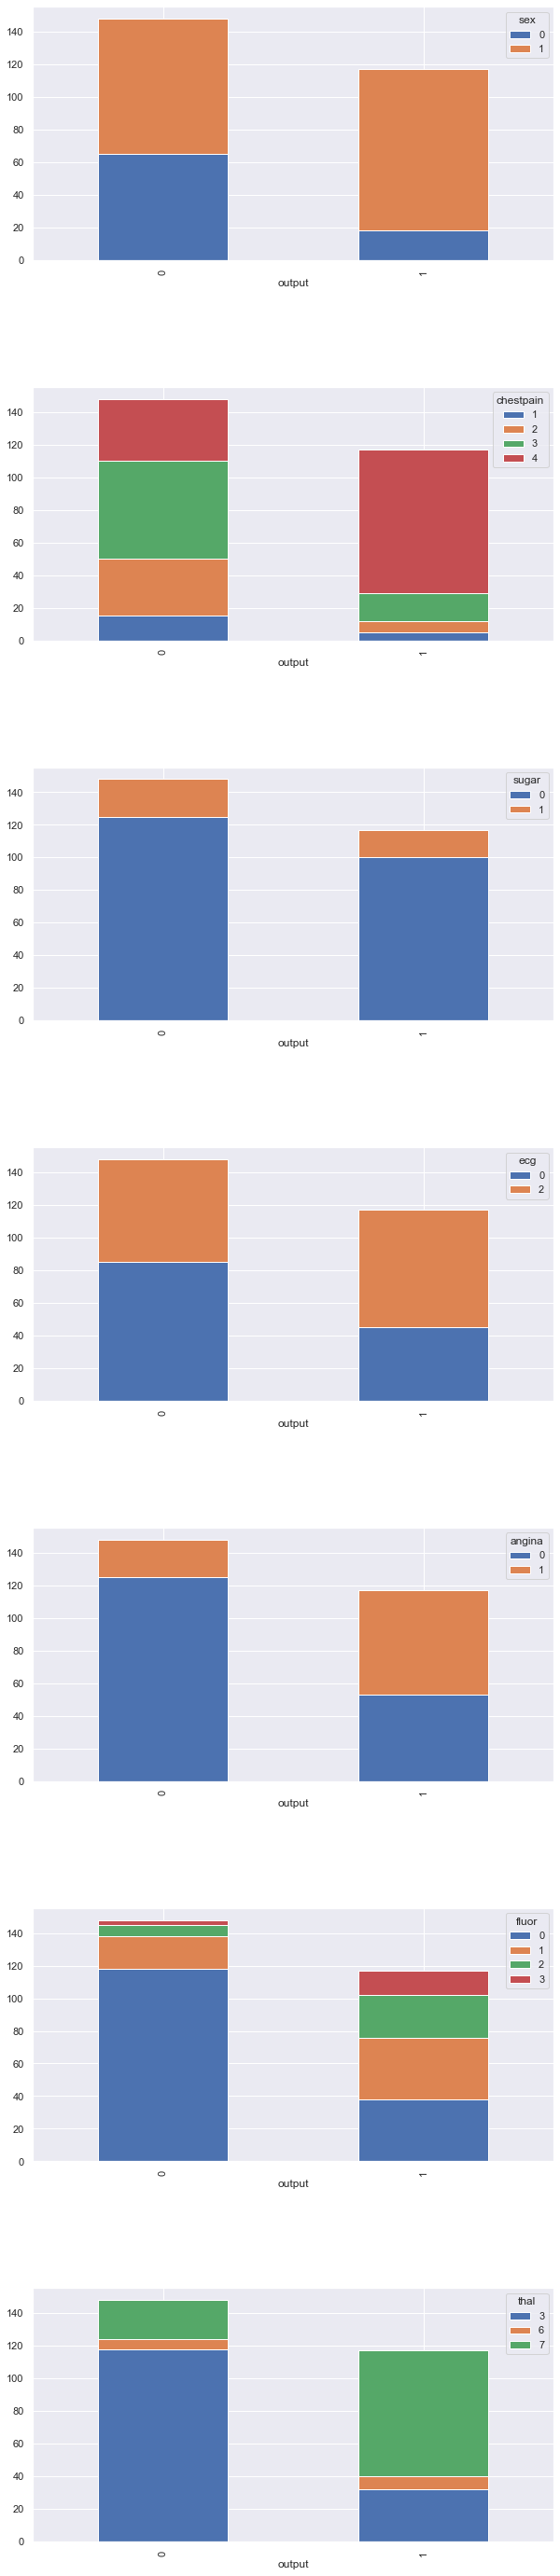

In [138]:
fig, ax = plt.subplots(len(cat_vars),1, figsize=(10,50))
plt.subplots_adjust(hspace=0.5)
for i,x in enumerate(cat_vars):
    pd.crosstab(df['output'],df[x]).plot.bar(stacked=True, ax=ax[i]);

For the plots above, most of the different categories for each categorical variable seems to have about a 50-50 chance of indicating heart disease. For example, the sugar variable shows that the makeup of those with higher than 120 mg/dl vs. lower than 120 mg/dl is about the same for those with and without heart disease. On the other hand, thal indicates that if thal is normal(3), there is a greater chance of not having heart disease, and if thal is reversable defect(7),  that it tends to indicate heart disease.

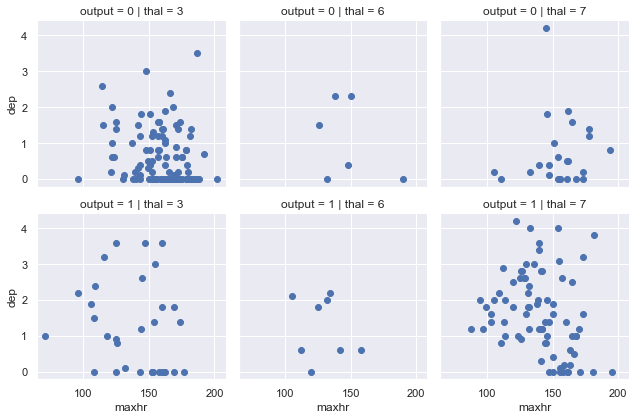

In [150]:
g = sns.FacetGrid(df, row='output', col='thal')
g.map(plt.scatter, 'maxhr', 'dep');

## Machine Learning

Now that I have done some data cleaning and exploration, I will begin the machine learning portion.

In [144]:
predictors=['thal', 'dep', 'maxhr']
X = df[predictors].values
y = df['output'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [154]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [159]:
blind_prediction = df['output'].value_counts().index[0]
baseline_accuracy = (y_test == blind_prediction).mean()
print("Baseline accuracy: {:.2f}".format(baseline_accuracy))

Baseline accuracy: 0.50


In [160]:
y_prediction = clf.predict(X_test)
test_accuracy = (y_test == y_prediction).mean()
print("Test accuracy: {:.2f}".format(test_accuracy))

Test accuracy: 0.79


Looking only at accuracy, the model is doing better than the baseline by 29%. However, because the data is very unbalanced, looking only at accuracy to determine if the model is good is not enough.

In [161]:
pd.crosstab(y_prediction, y_test)

col_0,0,1
row_0,,
0,33,10
1,7,30


In [165]:
print("Precision score: {:.2f}".format(precision_score(y_test, y_prediction)))
print("Recall score: {:.2f}".format(recall_score(y_test, y_prediction)))

Precision score: 0.81
Recall score: 0.75


Based on precision and recall, this model is better at accurately predicting having heart disease if it is present, but does not do as good of a job of catching all patients that have heart disease. If we were to use this model to tell patients whether or not they have heart disease, it would be better to improve the recall score so that we can cover more patients with heart disease.

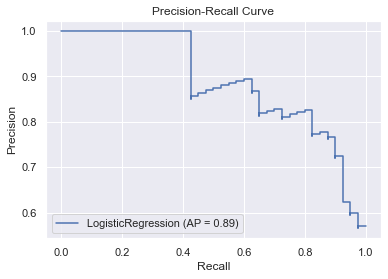

In [170]:
plot_precision_recall_curve(clf, X_test, y_test)
plt.title('Precision-Recall Curve');

Based on the precision recall curve, it would be best to get recall and precision at ~0.83.